<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

**Check relation betweeen dynamics and generalization.   Hypothesis to make: generalization can only be understood in level of joint dynamical system, there is a clear link between the two**

**Dynamnics determines generalization , not decoding , same decoding level can have very different dynamics , thus different generalization level.  Only when the dynamics of RNN forms object correspond to real relevant objects for game, the generalization can be good.   For instance , in a varying size game, you extend the size of game from 10 to 30, what will happen?  You can do a kind of dynamical programing , according to which wall you have seen and how many steps you have passed , you decide future action.    This can be achieved robustly by the dynamical system where fix points are correspond to walls**

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


## Packages

In [47]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import navigation2
from navigation2 import *

import Nets 
from Nets import *

import sklearn
from sklearn.svm import SVC
from sklearn.manifold import Isomap
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

import scipy
from scipy.spatial import distance
from scipy import signal

from operator import itemgetter 

from collections import Counter 
from itertools import chain 

import GLM_cells
from GLM_cells import *


%pylab inline
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

**What is the relation to head direction, this order kept in limit cycle**
**Could we define the order parameter for behaviour and link it to dynamics?**

# The GLM analysis of variance for different variables
The features include x, y, sensory,  action, last click memory , last twice click memory, the last twice click has a very strong contribution to features, but it inludes the last one click. In a sense, the integrated memory is not equalling to memroy 1 plus memory2 

In [48]:
# Put the stimulus memory(status) and action base for memory and navigation  
def Transform(States, Poss, Hiddens, Actions, Context, history = False, size = 15):
    # last click state
    Borders = np.concatenate([State_transform(state, poss, size)[0] for state, poss in zip(States, Poss)])
    Status = np.concatenate([State_transform(state, poss, size)[1] for state, poss in zip(States, Poss)])
    Hiddens = np.concatenate(Hiddens)
    Poss = np.concatenate(Poss)
    Actions = np.concatenate(Actions)
    Context = np.concatenate(Context)
    # transform state to stim　
    States = np.concatenate(States)
    # transform status to memory
    return Borders[Status>0], Poss[Status>0], Hiddens[Status>0], \
Actions[Status>0], Status[Status>0], Context[Status>0]

# histroy memory of two 
def history_summary(Status):
#     S = [p[0]  for s, p in zip(State, Poss)]
    M = np.zeros((len(Status), 2))
    m2 = 0
    for i, (s1, s2) in enumerate(zip(Status[:-1], Status[1:])): 
        # if next clicks changes, then store this click as a memory value registed in m2  
        if s2 != s1:
            m2 = s1
        # sore memory,  m0 as memory of stimulus, m1 as memory of second click    
        M[i+1, 0] = s2
        M[i+1, 1] = m2   
#         print (s1)
    return M  

def Stage_transform(State):
    S = np.cumsum([np.sum(s1 != s2) for (s1, s2) in zip(State[:-1], State[1:])] + [1]) 
    return S

# transform to space section
def wall_detection(pos, size):
    if pos[0] == 2:
        Stim = 1
    elif pos[0] == 2 + size - 1:
        Stim = 2
    elif pos[1] == 2:
        Stim = 3
    elif pos[1] == 2 + size - 1:
        Stim = 4
    else:
        Stim = 0 
    return Stim 

# for the memory feature, a Msimple one is just the last click, a most complicate one should be click sequence     
def State_transform(State, Poss, size):
#     S = [p[0]  for s, p in zip(State, Poss)]
    S = [wall_detection(pos, size) for pos in Poss]
    Status = []
    s1 = 0
    for s in S: 
        if s != 0: 
            s1 = s
#         print (s1)
        Status.append(s1)
    return S, Status
# histroy memory of two 
def history_summary(Status):
#     S = [p[0]  for s, p in zip(State, Poss)]
    M = np.zeros((len(Status), 2))
    m2 = 0
    for i, (s1, s2) in enumerate(zip(Status[:-1], Status[1:])): 
        # if next clicks changes, then store this click as a memory value registed in m2  
        if s2 != s1:
            m2 = s1
        # sore memory,  m0 as memory of stimulus, m1 as memory of second click    
        M[i+1, 0] = s2
        M[i+1, 1] = m2   
#         print (s1)
    return M

In [54]:
def Feature_preprocessing(States, Poss, Hiddens, Actions, Context, size = 15):
    States, Poss, Hiddens, Actions, Status, Context = Transform(States, Poss, Hiddens, \
                                                                        Actions, Context)
    x =  Hiddens[:, :512]
    z = (x - np.min(x))/(np.max(x) - np.min(x))
    y = np.log(z/(1-z + 1e-3) + 1e-3)
    A = np.array([np.eye(4)[a] for a in Actions]).reshape(-1, 4)
    Y = np.array([(y - size/2.) for y in Poss[:, 0] -2]).reshape(-1, 1)
    X = np.array([(x - size/2.) for x in Poss[:, 1] - 2]).reshape(-1, 1)
    M = np.array([np.eye(5)[s] for s in Status]).reshape(-1, 5)
    S = np.array([np.eye(5)[s] for s in States]).reshape(-1, 5)
#     S = np.array(States).reshape(-1, 9)
    C = np.array(Context).reshape(-1, 1)
    # S_wall = np.array([np.eye(27)[s] for s in Stim_wall]).reshape(-1, 27)
    Features = np.concatenate((A, Y, X, M, S, C), axis = 1)
    Features_A = np.concatenate((Y, X, M, S, C), axis = 1)
    Features_Y = np.concatenate((A, X, M, S, C), axis = 1)
    Features_X = np.concatenate((A, Y, M, S, C), axis = 1)
    Features_M = np.concatenate((A, Y, X, S, C), axis = 1)
    Features_S = np.concatenate((A, Y, X, M, C), axis = 1)
    Features_C = np.concatenate((A, Y, X, M, S), axis = 1)
    return y, Features, Features_A, Features_Y, Features_X, Features_M, Features_S, Features_C

def Feature_1_cell0(y, A, Y, X, M, S, C):
    Matrix_encode = np.zeros((512, 6))
    Clfs = []
    for i, feature in enumerate([A, Y, X, M, S, C]):
        clf = Lasso(alpha = 1e-3)
        # featues to num neurons 
        clf.fit(feature, y)
        y_pred = clf.predict(feature)
        Clfs.append(clf.coef_)
        for j in range(512):
            Matrix_encode[j, i] = r2_score(y[:, j], y_pred[:, j]) #- r2_score(y[:, j], np.ones_like(y[:, j])* np.mean(y[:, j]))
    return Matrix_encode, Clfs


def Feature_1_cell(y, A, Y, X, M, S, C, size = 15):
    # S_wall = np.array([np.eye(27)[s] for s in Stim_wall]).reshape(-1, 27)
    Features = [A, Y, X, M, S, C]
    Matrix_encode = np.zeros((512, 6))
    #  features
    Clfs = []
    for i in range(6):
        # neurons 
        clfs = []
        index = i
        # time x feature 
        features = Features[index].reshape(y.shape[0], -1)
        for j in range(512):
            # feature to 1 neuron
            clf = Lasso(alpha = 1e-3)
            clf.fit(features, y[:, j])
            y_pred = clf.predict(features)
            Matrix_encode[j, i] = r2_score(y[:, j] , y_pred[:])
            clfs.append(clf.coef_)
    Clfs.append(clfs)
    return Matrix_encode, Clfs

def Feature_1_cell_cv(y, A, Y, X, M, S, C, size = 15):
    # S_wall = np.array([np.eye(27)[s] for s in Stim_wall]).reshape(-1, 27)
    Features = [A, Y, X, M, S, C]
    Matrix_encode_train = np.zeros((512, 6, 5))
    Matrix_encode_test = np.zeros((512, 6, 5))
    #  features
    for i in range(6):
        # neurons 
        index = i
        # time x feature 
        features = Features[index].reshape(y.shape[0], -1)
        for j in range(512):
            # feature to 1 neuron
            cv = KFold(5, random_state = 0) 
            clf = Lasso(alpha = 1e-3)
            cv_scores = cross_validate(clf, features, y[:, j], cv=cv,
                         scoring=('r2'),
                         return_train_score = True)
            Matrix_encode_train[j, i] = cv_scores['train_score']  
            Matrix_encode_test[j, i] = cv_scores['test_score']  
    return Matrix_encode_train, Matrix_encode_test

def Feature_2_cell(y, A, Y, X, M, S, C, Matrix_encode, size = 15):
    # S_wall = np.array([np.eye(27)[s] for s in Stim_wall]).reshape(-1, 27)
    Features = [A, Y, X, M, S, C]
    Features_select = np.argmax(Matrix_encode, axis = 1)
    Matrix_encode = np.zeros((512, 6))
    #  features
    for i in range(6):
        # neurons 
        for j in range(512):
            # feature to 1 neuron
            index = np.array([Features_select[j], i])
            # time x feature 
            features = np.concatenate(itemgetter(*index)(Features), axis = 1).reshape(y.shape[0], -1)
            clf = Lasso(alpha = 1e-3)
            clf.fit(features, y[:, j])
            y_pred = clf.predict(features)
            Matrix_encode[j, i] = r2_score(y[:, j] , y_pred[:])
    return Matrix_encode


def Feature_2_cell_cv(y, A, Y, X, M, S, C, Matrix_encode, size = 15):
    # S_wall = np.array([np.eye(27)[s] for s in Stim_wall]).reshape(-1, 27)
    Features = [A, Y, X, M, S, C]
    Features_select = np.argmax(Matrix_encode, axis = 1)
    Matrix_encode_train = np.zeros((512, 6, 5))
    Matrix_encode_test = np.zeros((512, 6, 5))
    #  features
    for i in range(6):
        # neurons 
        for j in range(512):
            # feature to 1 neuron
            index = np.array([Features_select[j], i])
            # time x feature 
            features = np.concatenate(itemgetter(*index)(Features), axis = 1).reshape(y.shape[0], -1)
            clf = Lasso(alpha = 1e-3)
            clf.fit(features, y[:, j])
            cv = KFold(5, random_state = 0) 
            cv_scores = cross_validate(clf, features, y[:, j], cv=cv,
                         scoring=('r2'),
                         return_train_score = True)
            Matrix_encode_train[j, i] = cv_scores['train_score']  
            Matrix_encode_test[j, i] = cv_scores['test_score']   
    return Matrix_encode_train, Matrix_encode_test



def Feature_more(y, A, Y, X, M, S, C, Matrix_encodes, size = 15):
    # S_wall = np.array([np.eye(27)[s] for s in Stim_wall]).reshape(-1, 27)
    Features = [A, Y, X, M, S, C]
    Matrix_encode = np.zeros((512, 6))
    feature_selects = []
    for matrix in Matrix_encodes:
        feature_selects.append(np.argmax(matrix, axis = 1))
    #  features
    for i in range(6):
        # neurons 
        for j in range(512):
            # feature to 1 neuron
            index = []
            for k in range(len(Matrix_encodes)):
                index.append(feature_selects[k][j])
            index.append(i)
            index = np.array(index)   
            # time x feature 
            features = np.concatenate(itemgetter(*index)(Features), axis = 1).reshape(y.shape[0], -1)
            clf = Lasso(alpha = 1e-3)
            clf.fit(features, y[:, j])
            y_pred = clf.predict(features)
            Matrix_encode[j, i] = r2_score(y[:, j] , y_pred[:])
    return Matrix_encode

def Feature_more_cv(y, A, Y, X, M, S, C, Matrix_encodes, size = 15):
    # S_wall = np.array([np.eye(27)[s] for s in Stim_wall]).reshape(-1, 27)
    Features = [A, Y, X, M, S, C]
    Matrix_encode_train = np.zeros((512, 6, 5))
    Matrix_encode_test = np.zeros((512, 6, 5))
    feature_selects = []
    for matrix in Matrix_encodes:
        feature_selects.append(np.argmax(matrix, axis = 1))
    #  features
    for i in range(6):
        # neurons 
        for j in range(512):
            # feature to 1 neuron
            index = []
            for k in range(len(Matrix_encodes)):
                index.append(feature_selects[k][j])
            index.append(i)
            index = np.array(index)   
            # time x feature 
            features = np.concatenate(itemgetter(*index)(Features), axis = 1).reshape(y.shape[0], -1)
            clf = Lasso(alpha = 1e-3)
            clf.fit(features, y[:, j])
            cv = KFold(5, random_state = 0) 
            cv_scores = cross_validate(clf, features, y[:, j], cv=cv,
                         scoring=('r2'),
                         return_train_score = True)
            Matrix_encode_train[j, i] = cv_scores['train_score']  
            Matrix_encode_test[j, i] = cv_scores['test_score']    
    return Matrix_encode_train, Matrix_encode_test

In [55]:
# record sessions 100 for 2 different context, record the relevant variables 
def Data_record(weight, k_action = 1, epsilon = 0, size = 15, T = 200, seed_num = 1e3):
    PC_traces = []
    Hiddens = []
    Poss = []
    Actions = []
    States = []
    Context = []
    for i in range(T):
        torch.manual_seed(np.random.randint(seed_num))
        hidden0 = torch.randn(1, 512)
        c  = np.random.randint(2)
        start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
        game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 0 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, discount = 0.9, alpha = 1
                           ,lam = 0)
        game.net.load_state_dict(torch.load(weight))
        game.net.k_action = k_action 
        grid = game.grid.grid.copy()
        Pos, hidden, dh, Action, State, reward = trajectory(game, start, reward_control = c, size = size, \
                                                                  test = 0, limit_set = 4, init_hidden = False, hidden = hidden0, epsilon = epsilon)
        Hiddens.append(hidden)
        Poss.append(Pos[1:])
        Actions.append(Action)
        States.append(State)
        Context.append(c * np.ones(len(State)))
    return States, Poss, Hiddens, Actions, Context

## Echo Net

In [56]:
# record sessions 500 for 2 different context, record the relevant variables 
weight ='weights_fix1/rnn_1515tanh512_checkpoint300_0_5'
States1, Poss1, Hiddens1, Actions1, Context1 = Data_record(weight)
y, F, A, Y, X, M, S, C = Feature_preprocessing(States1, Poss1, Hiddens1, Actions1, Context1)
# Matrix_encode_echo, fs = Feature_1_cell0(y, A, Y, X, M, S, C)

In [57]:
Matrix0_encode1_cv_train, Matrix0_encode1_cv_test  = Feature_1_cell_cv(y, A, Y, X, M, S, C)

In [58]:
Matrix0_encode2_cv_train, Matrix0_encode2_cv_test  = Feature_2_cell_cv(y, A, Y, X, M, S, C, np.mean(Matrix0_encode1_cv_test, axis = 2))

In [59]:
M1 = np.mean(Matrix0_encode1_cv_test, axis = 2)
M2 = np.mean(Matrix0_encode2_cv_test, axis = 2)
Matrix0_encode3_cv_train, Matrix0_encode3_cv_test = Feature_more_cv(y, A, Y, X, M, S, C, [M1, M2])
M1 = np.mean(Matrix0_encode1_cv_test, axis = 2)
M2 = np.mean(Matrix0_encode2_cv_test, axis = 2)
M3 = np.mean(Matrix0_encode3_cv_test, axis = 2)
Matrix0_encode4_cv_train, Matrix0_encode4_cv_test = Feature_more_cv(y, A, Y, X, M, S, C, [M1, M2, M3])
M1 = np.mean(Matrix0_encode1_cv_test, axis = 2)
M2 = np.mean(Matrix0_encode2_cv_test, axis = 2)
M3 = np.mean(Matrix0_encode3_cv_test, axis = 2)
M4 = np.mean(Matrix0_encode4_cv_test, axis = 2)
Matrix0_encode5_cv_train, Matrix0_encode5_cv_test = Feature_more_cv(y, A, Y, X, M, S, C, [M1, M2, M3, M4])
M1 = np.mean(Matrix0_encode1_cv_test, axis = 2)
M2 = np.mean(Matrix0_encode2_cv_test, axis = 2)
M3 = np.mean(Matrix0_encode3_cv_test, axis = 2)
M4 = np.mean(Matrix0_encode4_cv_test, axis = 2)
M5 = np.mean(Matrix0_encode5_cv_test, axis = 2)
Matrix0_encode6_cv_train, Matrix0_encode6_cv_test = Feature_more_cv(y, A, Y, X, M, S, C, [M1, M2, M3, M4, M5])

plt.hist(Matrix_encode.ravel())

0.2189291597428315 0.24342679087722635 0.24352467188316704 0.2435247285511726 0.2435247504427847 0.2435247452512104


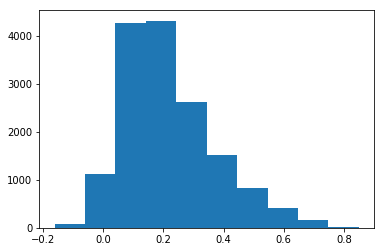

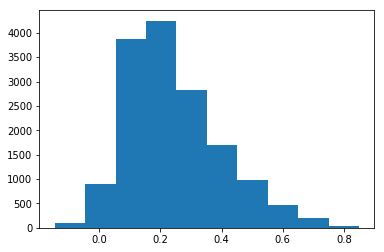

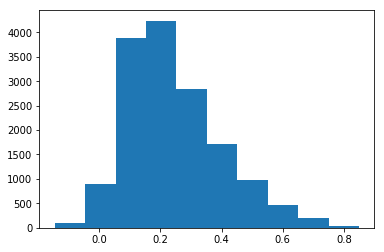

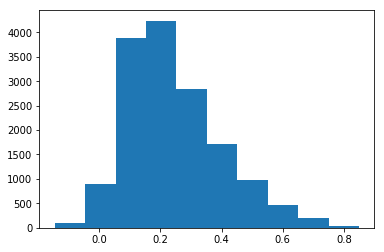

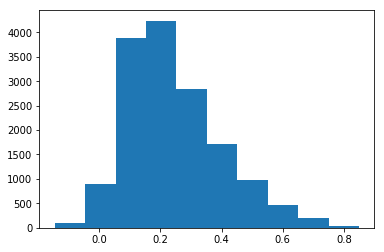

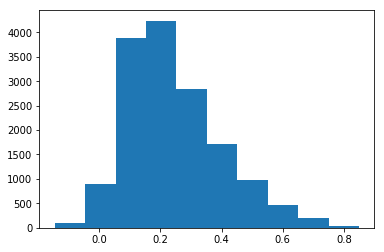

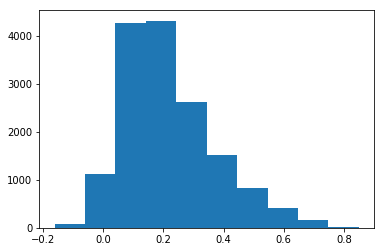

In [31]:
plt.hist(Matrix0_encode1_cv_test.ravel())
plt.figure()
plt.hist(Matrix0_encode2_cv_test.ravel())
plt.figure()
plt.hist(Matrix0_encode3_cv_test.ravel())
plt.figure()
plt.hist(Matrix0_encode4_cv_test.ravel())
plt.figure()
plt.hist(Matrix0_encode5_cv_test.ravel())
plt.figure()
plt.hist(Matrix0_encode6_cv_test.ravel())
plt.figure()
plt.hist(Matrix0_encode1_cv_test.ravel())
print (np.mean(Matrix0_encode1_cv_test.ravel()), np.mean(Matrix0_encode2_cv_test.ravel()), np.mean(Matrix0_encode3_cv_test.ravel()),
np.mean(Matrix0_encode4_cv_test.ravel()), np.mean(Matrix0_encode5_cv_test.ravel()), np.mean(Matrix0_encode6_cv_test.ravel()))

In [32]:
np.save('Matrix0_encode1_cv_test', Matrix0_encode1_cv_test)
np.save('Matrix0_encode2_cv_test', Matrix0_encode2_cv_test)
np.save('Matrix0_encode3_cv_test', Matrix0_encode3_cv_test)
np.save('Matrix0_encode4_cv_test', Matrix0_encode4_cv_test)
np.save('Matrix0_encode5_cv_test', Matrix0_encode5_cv_test)
np.save('Matrix0_encode6_cv_test', Matrix0_encode6_cv_test)

In [33]:
Matrix0_encode1_cv_test = np.load('Matrix0_encode1_cv_test.npy')
Matrix0_encode2_cv_test = np.load('Matrix0_encode2_cv_test.npy')
Matrix0_encode3_cv_test = np.load('Matrix0_encode3_cv_test.npy')
Matrix0_encode4_cv_test = np.load('Matrix0_encode4_cv_test.npy')
Matrix0_encode5_cv_test = np.load('Matrix0_encode5_cv_test.npy')
Matrix0_encode6_cv_test = np.load('Matrix0_encode6_cv_test.npy')

(array([ 39.,   0., 134.,   0.,  40.,   0., 131.,   0.,  12., 156.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

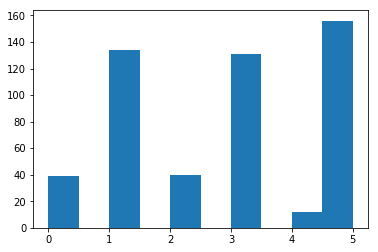

In [34]:
plt.hist(np.argmax(np.mean(Matrix0_encode1_cv_test, axis = 2), axis = 1))


In [49]:
n = 5
T = []
Single = []
Out = []
Filter= []
for i in range(512):
    index_select1 = np.argmax(np.mean(Matrix0_encode1_cv_test, axis = 2)[i])
    index_select2 = np.argmax(np.mean(Matrix0_encode2_cv_test, axis = 2)[i])
#     print (Matrix0_encode1_cv_test[i, index_select1], Matrix0_encode2_cv_test[i, index_select2])
    # difference
    dif = (Matrix0_encode2_cv_test[i, index_select2] - Matrix0_encode1_cv_test[i, index_select1])
    # std
    var = np.std(dif)/np.sqrt(n - 1)
    # t  
    t = np.mean(dif)/var
    T.append(t)
    if t<=3.:
        Single.append(index_select1)
    if t>3.:
        Filter.append(i)
        Out.append((index_select1, index_select2))
print (len(Single))
n = 5
T = []
Duo = []
Out2 = []
Filter2 = []
for i, index in zip(Filter, Out):
    index_select2 = np.argmax(np.mean(Matrix0_encode2_cv_test, axis = 2)[i])
    index_select3 = np.argmax(np.mean(Matrix0_encode3_cv_test, axis = 2)[i])
#     print (Matrix0_encode1_cv_test[i, index_select1], Matrix0_encode2_cv_test[i, index_select2])
    # difference
    dif = (Matrix0_encode3_cv_test[i, index_select3] - Matrix0_encode2_cv_test[i, index_select2])
    # std
    var = np.std(dif)/np.sqrt(n - 1)
    # t  
    t = np.mean(dif)/var
    T.append(t)
    if t<=3:
        Duo.append(index)
    if t>3:
        Filter2.append(i)
        Out2.append((index[0], index[1], index_select3))
        

n = 5
T = []
Triple = []
Out3 = []
Filter3 = []
for i, index in zip(Filter2, Out2):
    index_select3 = np.argmax(np.mean(Matrix0_encode3_cv_test, axis = 2)[i])
    index_select4 = np.argmax(np.mean(Matrix0_encode4_cv_test, axis = 2)[i])
#     print (Matrix0_encode1_cv_test[i, index_select1], Matrix0_encode2_cv_test[i, index_select2])
    # difference
    dif = (Matrix0_encode4_cv_test[i, index_select4] - Matrix0_encode3_cv_test[i, index_select3])
    # std
    var = np.std(dif)/np.sqrt(n - 1)
    # t  
    t = np.mean(dif)/var
    T.append(t)
    if t<=3.:
        Triple.append(index)
    if t>3.:
        Filter3.append(i)
        Out3.append((index[0], index[1], index[2], index_select4))

n = 5
T = []
Quadro = []
Out4 = []
Filter4 = []
for i, index in zip(Filter3, Out3):
    index_select4 = np.argmax(np.mean(Matrix0_encode4_cv_test, axis = 2)[i])
    index_select5 = np.argmax(np.mean(Matrix0_encode5_cv_test, axis = 2)[i])
#     print (Matrix0_encode1_cv_test[i, index_select1], Matrix0_encode2_cv_test[i, index_select2])
    # difference
    dif = (Matrix0_encode5_cv_test[i, index_select5] - Matrix0_encode4_cv_test[i, index_select4])
    # std
    var = np.std(dif)/np.sqrt(n - 1)
    # t  
    t = np.mean(dif)/var
    T.append(t)
    if t<=3.:
        Quadro.append(index)
    if t>3.:
        Filter4.append(i)
        Out4.append((index[0], index[1], index[2], index[3], index_select5))
        
        
n = 5
T = []
Five = []
Out5 = []
Filter5 = []
for i, index in zip(Filter4, Out4):
    index_select5 = np.argmax(np.mean(Matrix0_encode5_cv_test, axis = 2)[i])
    index_select6 = np.argmax(np.mean(Matrix0_encode6_cv_test, axis = 2)[i])
#     print (Matrix_encode1_cv_test[i, index_select1], Matrix_encode2_cv_test[i, index_select2])
    # difference
    dif = (Matrix0_encode6_cv_test[i, index_select6] - Matrix0_encode5_cv_test[i, index_select5])
    # std
    var = np.std(dif)/np.sqrt(n - 1)
    # t  
    t = np.mean(dif)/var
    T.append(t)
    if t<=3.:
        Five.append(index)
    if t>3.:
        Filter5.append(i)
        Out5.append((index[0], index[1], index[2], index[3], index[4], index_select6))

494


In [53]:
len(Single)

494

[3. 3. 1. 2. 1. 1. 1. 1. 3. 2.] {(0, 0), (5, 5), (3, 3), (2, 1), (1, 5), (3, 4), (5, 1), (4, 1), (1, 1), (4, 0)}


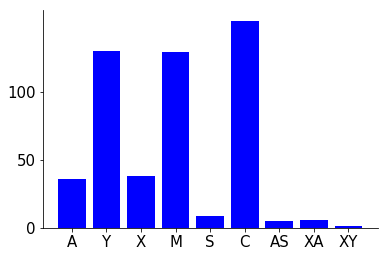

In [50]:
unique1, freq1 = np.unique(Single, return_counts = True)
unique2, indice, inverse, freq2 = np.unique(Duo, return_counts = True, return_index = True, return_inverse = True)

# freq = np.insert(freq, 1, 0)
# freq
len(freq1)
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.bar(range(9), height = list(freq1) + list([5, 6, 1]), color = 'b')
plt.yticks([0, 50, 100], size = 15)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['A', 'Y', 'X', 'M', 'S', 'C', 'AS', 'XA', 'XY'], size = 15)
num_s = np.zeros(len(set(list(Duo))))
for i, s in enumerate(set(list(Duo))):
#     print (s)
    for d in Duo:
#         print (d)
#         print (d == s)
        num_s[i] += int((d == s))

print (num_s, set(list(Duo)))

In [43]:
# Output = Counter(chain(*Duo)) 
Set = set(Duo)
    
dict_ = np.array(list(Set))
Dict_ = {} 
for s in Set:

    num =Duo.count((s[0], s[1]))
    Dict_.update([(s, num)] )
    print (s, num)
# plt.bar(range(len(Dict_)), list(Dict_.values()), align='center')
# plt.xticks(range(len(Dict_)), list(Dict_.keys()))



(0, 0) 3
(5, 5) 3
(3, 3) 1
(2, 1) 2
(1, 5) 1
(3, 4) 1
(5, 1) 1
(4, 1) 1
(1, 1) 3
(4, 0) 2


In [44]:
Set = set(Triple)
    
dict_ = np.array(list(Set))
Dict_ = {} 
for s in Set:

    num =Duo.count((s[0], s[1]))
    Dict_.update([(s, num)] )
    print (s, num)
# plt.bar(range(len(D

for i in range(5):
    index_select4 = np.argmax(np.mean(Matrix0_encode4_cv_test, axis = 2)[i])
    index_select5 = np.argmax(np.mean(Matrix0_encode5_cv_test, axis = 2)[i])
    dif = (Matrix0_encode4_cv_test[i, index_select4] - Matrix0_encode5_cv_test[i, index_select5])
    print (Matrix0_encode4_cv_test[i, index_select4], Matrix0_encode5_cv_test[i, index_select5])
    print (dif)
    sign = (np.sign(dif))
    print (sign)
    rank =  (np.argsort(np.abs(dif)))
    print (rank)
    rank_sign = sign[rank] * rank
    print (np.sum(rank_sign))

([<matplotlib.axis.XTick at 0x7f99cc8f0cc0>,
 <a list of 6 Text xticklabel objects>)

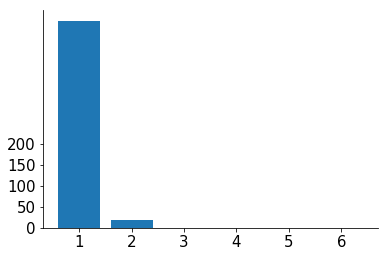

In [45]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
List = [len(Single), len(Duo), len(Triple), len(Quadro), len(Five), len(Out5)]
plt.bar(range(6), height = List)
plt.yticks([0, 50, 100, 150, 200], size = 15)
plt.xticks([0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6], size = 15)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

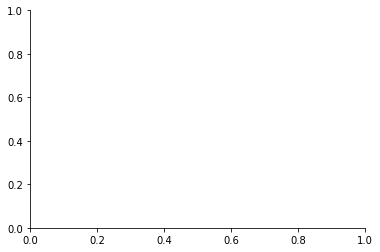

In [46]:
unique, freq = np.unique(Single, return_counts = True)
unique, freq
freq = np.insert(freq, 1, 0)
freq
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.bar(range(6), height = freq)
plt.yticks([0, 50, 100], size = 15)
plt.xticks([1, 2, 3, 4, 5, 6], ['A', 'Y', 'X', 'M', 'S', 'C'], size = 15)

In [39]:
M_dif = Matrix_encode2_echo - Matrix_encode_echo
index2 = np.where(M_dif>0.2)

M_dif = Matrix_encode3_echo - Matrix_encode2_echo
index3 = np.where(M_dif>0.2)
# index_0[index[0]], Matrix_encode_2[M_dif>0.1], index[1]
Type = np.concatenate((index_0[index[0]].reshape(-1, 1), index2[1].reshape(-1, 1), index3[1].reshape(-1, 1)), axis = 1)
dict_ = {0: 'A', 1:'Y', 2:'X', 3:'M', 4:'S', 5:'C'}
Type_ = [(dict_[type_[0]], dict_[type_[1]], dict_[type_[2]]) for type_ in Type]
Type_

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [50]:
M_dif = Matrix_encode2 - Matrix_encode
index = np.where(M_dif>0.1)
# index_0[index[0]], Matrix_encode_2[M_dif>0.1], index[1]
Type = np.concatenate((index_0[index[0]].reshape(-1, 1), index[1].reshape(-1, 1)), axis = 1)
dict_ = {0: 'A', 1:'Y', 2:'X', 3:'M', 4:'S', 5:'C'}
Type_ = [(dict_[type_[0]], dict_[type_[1]]) for type_ in Type]
# Type_

In [8]:
M_dif = Matrix_encode3 - Matrix_encode2
index2 = np.where(M_dif>0.1)
# print (len(index2))
# index_0[index[0]], Matrix_encode_2[M_dif>0.1], index[1]
Type = np.concatenate((index_0[index[0]].reshape(-1, 1), index[1].reshape(-1, 1), index2[1].reshape(-1, 1)), axis = 1)
dict_ = {0: 'A', 1:'Y', 2:'X', 3:'M', 4:'S', 5:'C'}
Type2_ = [(dict_[type_[0]], dict_[type_[1]],  dict_[type_[2]]) for type_ in Type]

NameError: name 'Matrix_encode3' is not defined

### Pretrain Net

In [32]:
# record sessions 500 for 2 different context, record the relevant variables 
weight ='weights_fix/weights1/rnn_1515tanh512_checkpoint39_2_9'
States1, Poss1, Hiddens1, Actions1, Context1 = Data_record(weight)
y, A, Y, X, M, S, C = Feature_preprocessing(States1, Poss1, Hiddens1, Actions1, Context1)
Matrix_encode1_cv_train, Matrix_encode1_cv_test  = Feature_1_cell_cv(y, A, Y, X, M, S, C)

(4332, 9) (4332, 2)


0.09226096785125347

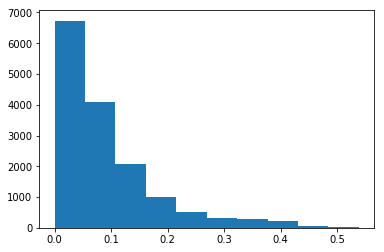

In [39]:
plt.hist(Matrix_encode1_cv_train.ravel())
np.mean(Matrix_encode1_cv_train.ravel())

0.07135714760294196

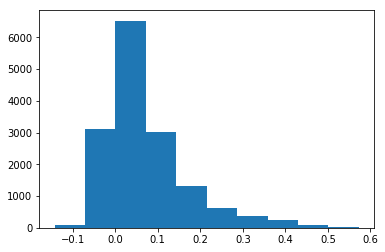

In [40]:
plt.hist(Matrix_encode1_cv_test.ravel())
np.mean(Matrix_encode1_cv_test.ravel())

(array([ 19.,   0.,   1.,   0., 348.,   0.,  93.,   0.,  39.,  12.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

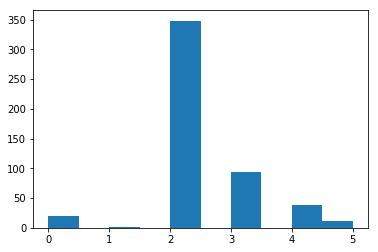

In [41]:
plt.hist(np.argmax(np.mean(Matrix_encode1_cv_test, axis = 2), axis = 1))


In [33]:
Matrix_encode2_cv_train, Matrix_encode2_cv_test  = Feature_2_cell_cv(y, A, Y, X, M, S, C, np.mean(Matrix_encode1_cv_test, axis = 2))

0.22384057687307077

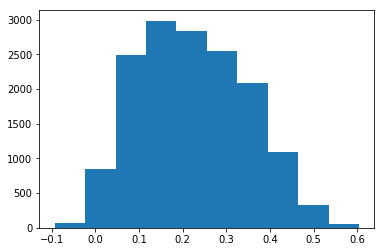

In [42]:
plt.hist(Matrix_encode2_cv_test.ravel())
np.mean(Matrix_encode2_cv_test.ravel())

In [34]:
M1 = np.mean(Matrix_encode1_cv_test, axis = 2)
M2 = np.mean(Matrix_encode2_cv_test, axis = 2)
Matrix_encode3_cv_train, Matrix_encode3_cv_test = Feature_more_cv(y, A, Y, X, M, S, C, [M1, M2])

0.2648143560305032

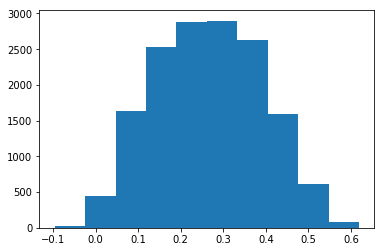

In [43]:
plt.hist(Matrix_encode3_cv_test.ravel())
np.mean(Matrix_encode3_cv_test.ravel())

In [35]:
M1 = np.mean(Matrix_encode1_cv_test, axis = 2)
M2 = np.mean(Matrix_encode2_cv_test, axis = 2)
M3 = np.mean(Matrix_encode3_cv_test, axis = 2)
Matrix_encode4_cv_train, Matrix_encode4_cv_test = Feature_more_cv(y, A, Y, X, M, S, C, [M1, M2, M3])

0.28734502859686584

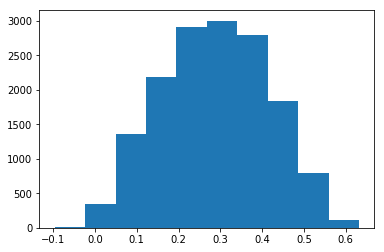

In [44]:
plt.hist(Matrix_encode4_cv_test.ravel())
np.mean(Matrix_encode4_cv_test.ravel())

In [36]:
M1 = np.mean(Matrix_encode1_cv_test, axis = 2)
M2 = np.mean(Matrix_encode2_cv_test, axis = 2)
M3 = np.mean(Matrix_encode3_cv_test, axis = 2)
M4 = np.mean(Matrix_encode4_cv_test, axis = 2)
Matrix_encode5_cv_train, Matrix_encode5_cv_test = Feature_more_cv(y, A, Y, X, M, S, C, [M1, M2, M3, M4])

In [37]:
M1 = np.mean(Matrix_encode1_cv_test, axis = 2)
M2 = np.mean(Matrix_encode2_cv_test, axis = 2)
M3 = np.mean(Matrix_encode3_cv_test, axis = 2)
M4 = np.mean(Matrix_encode4_cv_test, axis = 2)
M5 = np.mean(Matrix_encode5_cv_test, axis = 2)
Matrix_encode6_cv_train, Matrix_encode6_cv_test = Feature_more_cv(y, A, Y, X, M, S, C, [M1, M2, M3, M4, M5])

In [306]:
np.save('Matrix_encode1_cv_test', Matrix_encode1_cv_test)
np.save('Matrix_encode2_cv_test', Matrix_encode2_cv_test)
np.save('Matrix_encode3_cv_test', Matrix_encode3_cv_test)
np.save('Matrix_encode4_cv_test', Matrix_encode4_cv_test)
np.save('Matrix_encode5_cv_test', Matrix_encode5_cv_test)
np.save('Matrix_encode6_cv_test', Matrix_encode6_cv_test)

In [56]:
Matrix_encode1_cv_test = np.load('Matrix_encode1_cv_test.npy')
Matrix_encode2_cv_test = np.load('Matrix_encode2_cv_test.npy')
Matrix_encode3_cv_test = np.load('Matrix_encode3_cv_test.npy')
Matrix_encode4_cv_test = np.load('Matrix_encode4_cv_test.npy')
Matrix_encode5_cv_test = np.load('Matrix_encode5_cv_test.npy')
Matrix_encode6_cv_test = np.load('Matrix_encode6_cv_test.npy')

In [97]:
n = 5
T = []
Single = []
Out = []
Filter= []
for i in range(512):
    index_select1 = np.argmax(np.mean(Matrix_encode1_cv_test, axis = 2)[i])
    index_select2 = np.argmax(np.mean(Matrix_encode2_cv_test, axis = 2)[i])
#     print (Matrix_encode1_cv_test[i, index_select1], Matrix_encode2_cv_test[i, index_select2])
    # difference
    dif = (Matrix_encode2_cv_test[i, index_select2] - Matrix_encode1_cv_test[i, index_select1])
    # std
    var = np.std(dif)/np.sqrt(n - 1)
    # t  
    t = np.mean(dif)/var
    T.append(t)
    if t<=3.:
        Single.append(index_select1)
    if t>3.:
        Filter.append(i)
        Out.append((index_select1, index_select2))
print (len(Single))

n = 5
T = []
Duo = []
Out2 = []
Filter2 = []
for i, index in zip(Filter, Out):
    index_select2 = np.argmax(np.mean(Matrix_encode2_cv_test, axis = 2)[i])
    index_select3 = np.argmax(np.mean(Matrix_encode3_cv_test, axis = 2)[i])
#     print (Matrix_encode1_cv_test[i, index_select1], Matrix_encode2_cv_test[i, index_select2])
    # difference
    dif = (Matrix_encode3_cv_test[i, index_select3] - Matrix_encode2_cv_test[i, index_select2])
    # std
    var = np.std(dif)/np.sqrt(n - 1)
    # t  
    t = np.mean(dif)/var
    T.append(t)
    if t<=3:
        Duo.append(index)
    if t>3.:
        Filter2.append(i)
        Out2.append((index[0], index[1], index_select3))
        

n = 5
T = []
Triple = []
Out3 = []
Filter3 = []
for i, index in zip(Filter2, Out2):
    index_select3 = np.argmax(np.mean(Matrix_encode3_cv_test, axis = 2)[i])
    index_select4 = np.argmax(np.mean(Matrix_encode4_cv_test, axis = 2)[i])
#     print (Matrix_encode1_cv_test[i, index_select1], Matrix_encode2_cv_test[i, index_select2])
    # difference
    dif = (Matrix_encode4_cv_test[i, index_select4] - Matrix_encode3_cv_test[i, index_select3])
    # std
    var = np.std(dif)/np.sqrt(n - 1)
    # t  
    t = np.mean(dif)/var
    T.append(t)
    if t<=3.:
        Triple.append(index)
    if t>3.:
        Filter3.append(i)
        Out3.append((index[0], index[1], index[2], index_select4))

n = 5
T = []
Quadro = []
Out4 = []
Filter4 = []
for i, index in zip(Filter3, Out3):
    index_select4 = np.argmax(np.mean(Matrix_encode4_cv_test, axis = 2)[i])
    index_select5 = np.argmax(np.mean(Matrix_encode5_cv_test, axis = 2)[i])
#     print (Matrix_encode1_cv_test[i, index_select1], Matrix_encode2_cv_test[i, index_select2])
    # difference
    dif = (Matrix_encode5_cv_test[i, index_select5] - Matrix_encode4_cv_test[i, index_select4])
    # std
    var = np.std(dif)/np.sqrt(n - 1)
    # t  
    t = np.mean(dif)/var
    T.append(t)
    if t<=3.:
        Quadro.append(index)
    if t>3.:
        Filter4.append(i)
        Out4.append((index[0], index[1], index[2], index[3], index_select5))
        
n = 5
T = []
Five = []
Out5 = []
Filter5 = []
for i, index in zip(Filter4, Out4):
    index_select5 = np.argmax(np.mean(Matrix_encode5_cv_test, axis = 2)[i])
    index_select6 = np.argmax(np.mean(Matrix_encode6_cv_test, axis = 2)[i])
#     print (Matrix_encode1_cv_test[i, index_select1], Matrix_encode2_cv_test[i, index_select2])
    # difference
    dif = (Matrix_encode6_cv_test[i, index_select6] - Matrix_encode5_cv_test[i, index_select5])
    # std
    var = np.std(dif)/np.sqrt(n - 1)
    # t  
    t = np.mean(dif)/var
    T.append(t)
    if t<=3.:
        Five.append(index)
    if t>3.:
        Filter5.append(i)
        Out5.append((index[0], index[1], index[2], index[3], index[4], index_select6))

148


([<matplotlib.axis.XTick at 0x7f40a15eea20>,
 <a list of 6 Text xticklabel objects>)

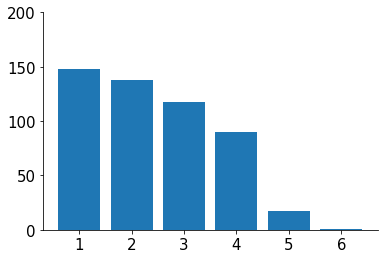

In [58]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
List = [len(Single), len(Duo), len(Triple), len(Quadro), len(Five), len(Out5)]
plt.bar(range(6), height = List)
plt.yticks([0, 50, 100, 150, 200], size = 15)
plt.xticks([0, 1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 6], size = 15)

[ 1.  1.  1.  2.  2.  2.  4. 22. 31.  5.  1. 27.  8.  9. 19.  2.  1.] {(5, 1), (3, 2), (5, 4), (3, 0), (3, 1), (4, 0), (2, 1), (2, 0), (2, 3), (0, 4), (4, 3), (2, 4), (4, 2), (2, 5), (3, 4), (0, 2), (0, 3)}


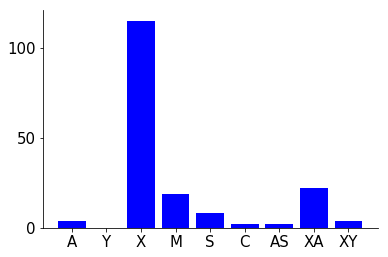

In [100]:

unique1, freq1 = np.unique(Single, return_counts = True)
unique2, indice, inverse, freq2 = np.unique(Duo, return_counts = True, return_index = True, return_inverse = True)

freq1 = np.insert(freq1, 1, 0)
# freq
len(freq1)
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.bar(range(9), height = list(freq1) + list([2, 22, 4]), color = 'b')
plt.yticks([0, 50, 100], size = 15)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['A', 'Y', 'X', 'M', 'S', 'C', 'AS', 'XA', 'XY'], size = 15)
num_s = np.zeros(len(set(list(Duo))))
for i, s in enumerate(set(list(Duo))):
#     print (s)
    for d in Duo:
#         print (d)
#         print (d == s)
        num_s[i] += int((d == s))

print (num_s, set(list(Duo)))

<Container object of 5 artists>

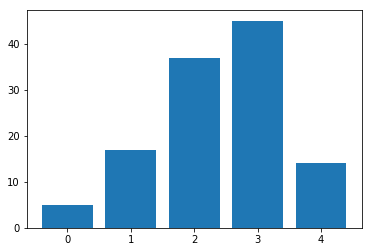

In [255]:
List = [len(set(Single)), len(set(Duo)), len(set(Triple)), len(set(Quadro)), len(set(Five))]
plt.bar(range(5), height = List)

In [283]:
# Output = Counter(chain(*Duo)) 
Set = set(Duo)
    
dict_ = np.array(list(Set))
Dict_ = {} 
for s in Set:

    num =Duo.count((s[0], s[1]))
    Dict_.update([(s, num)] )
    print (s, num)

(5, 1) 1
(3, 2) 1
(5, 4) 1
(3, 0) 2
(3, 1) 2
(4, 0) 2
(2, 1) 4
(2, 0) 22
(2, 3) 31
(0, 4) 5
(4, 3) 1
(2, 4) 27
(4, 2) 8
(2, 5) 9
(3, 4) 19
(0, 2) 2
(0, 3) 1
